In [7]:
# imports
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

In [8]:
def report(y_test, y_pred_labels):
    print("Classification Report:")
    print(classification_report(y_test, y_pred_labels))

In [9]:
import torch
import torch.nn as nn
from torchmetrics.classification import MulticlassAccuracy, MulticlassRecall, MulticlassPrecision, MulticlassF1Score, MulticlassConfusionMatrix
from torchmetrics import MetricCollection

class Net(nn.Module):
    def __init__(
        self,
        in_channels: int = 1,
        out_channels: int = 10,
        learning_rate: float = 1e-3,
        metrics: MetricCollection = None,
        confusion_matrix: MulticlassConfusionMatrix = None,
        seed: int = None
    ):
        super().__init__()

        # Default metrics if none provided
        if metrics is None:
            metrics = MetricCollection([
                MulticlassAccuracy(num_classes=out_channels),
                MulticlassPrecision(num_classes=out_channels),
                MulticlassRecall(num_classes=out_channels),
                MulticlassF1Score(num_classes=out_channels)
            ])

        # Clone metrics for train / validation / test
        self.train_metrics = metrics.clone(prefix="Train/")
        self.val_metrics   = metrics.clone(prefix="Validation/")
        self.test_metrics  = metrics.clone(prefix="Test/")

        # Confusion matrix metric, if not provided
        if confusion_matrix is None:
            self.cm = MulticlassConfusionMatrix(num_classes=out_channels)

        # Set random seed for reproducibility
        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

        # Example input (useful e.g. for TorchScript tracing)
        self.example_input_array = torch.zeros(1, in_channels, 28, 28)

        # Training hyperparameters
        self.learning_rate = learning_rate
        self.criterion     = nn.CrossEntropyLoss()

        # Fully-connected layers
        self.l1 = nn.Linear(28 * 28, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, out_channels)

        # Global epoch counters (optional)
        self.epoch_global_number = {"Train": 0, "Validation": 0, "Test": 0}

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass:
         - x is of shape (batch_size, in_channels, 28, 28)
         - returns log-probabilities of shape (batch_size, out_channels)
        """
        batch_size = x.size(0)

        # Flatten: (b, 1, 28, 28) → (b, 28*28)
        x = x.view(batch_size, -1)
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.l3(x)
        return torch.log_softmax(x, dim=1)

In [10]:
def model_analysis(model_path):
    # Load the previously trained model
    model = Net() # Initialize the model structure
    state = torch.load(os.path.join(os.getcwd(), model_path))
    model.load_state_dict(state)
    model.eval()  # Ensure the model is in evaluation mode
    
    # Display the model summary
    print(model)

    # Function to show the model's structure and its parameters
    def count_params(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    num_params = count_params(model)
    print(f'Number of trainable parameters: {num_params}')

    # Define transformations for images
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert images to tensors
    ])

    # Load the MNIST test dataset
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Evaluate the model with the test data
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    images_sample = []
    labels_sample = []
    preds_sample = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in test_loader:
            outputs = model(images)  # Pass the images through the model
            _, predicted = torch.max(outputs, 1)  # Get the predictions
            total += labels.size(0)  # Count the number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Save some images and predictions for visualization
            if len(images_sample) < 10:
                images_sample.extend(images[:10].cpu())
                labels_sample.extend(labels[:10].cpu().numpy())
                preds_sample.extend(predicted[:10].cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f'Model accuracy on the MNIST test set: {accuracy * 100:.2f}%')

    # Accuracy plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(all_labels[:100], all_preds[:100], 'bo', label='Predictions vs True Labels')
    ax.set_xlabel('True Labels')
    ax.set_ylabel('Predictions')
    ax.set_title('Comparison of Predictions with True Labels')
    ax.legend()
    plt.show()

    # Image with predictions plot
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    axes = axes.ravel()
    for i in np.arange(10):
        axes[i].imshow(images_sample[i].squeeze(), cmap='gray')
        axes[i].set_title(f"True: {labels_sample[i]} Pred: {preds_sample[i]}")
        axes[i].axis('off')
    plt.show()
    
    # Classification_report
    report(all_labels, all_preds)


In [11]:
from typing import Optional
import requests
import re
from pathlib import Path

def download_model_notebook(
    base_url: str,
    scenario_name: str,
    metric: Optional[str] = None,
    round: Optional[int] = None,
    participant: Optional[int] = None,
    save_dir: str = "."
) -> Path:
    """
    Download models from the FastAPI endpoint and save them to save_dir.

    - If both 'metric' and 'round' are None, downloads a ZIP containing all models.
    - If 'round' is not None, downloads that specific .pth model.
    - If 'metric' is not None, downloads the best .pth model according to that metric.
    - If 'participant' is not None, filters to only that participant's models.
      (participant must be an integer, e.g. 3 → "participant_3")
    """
    # Build the URL and query parameters
    url = f"{base_url.rstrip('/')}/api/robust/model/{scenario_name}"
    params = {}
    if metric:
        params["metric"] = metric
    if round is not None:
        params["round"] = round
    if participant is not None:
        params["participant"] = participant

    # Send the request in streaming mode
    resp = requests.get(url, params=params, stream=True)
    resp.raise_for_status()

    # Extract filename from Content-Disposition header
    cd = resp.headers.get("content-disposition", "")
    match = re.search(r'filename="?([^";]+)"?', cd)
    if match:
        filename = match.group(1)
    else:
        # Fallback naming
        if round is not None:
            filename = f"{scenario_name}_round_{round}_model.pth"
        elif metric:
            filename = f"{scenario_name}_{metric}_best_model.pth"
        else:
            filename = f"{scenario_name}_models.zip"

        if participant is not None:
            filename = filename.replace(
                scenario_name,
                f"{scenario_name}_participant_{participant}"
            )

    # Prepare save path
    save_path = Path(save_dir) / filename
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Stream-to-file
    with open(save_path, "wb") as f:
        for chunk in resp.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

    return save_path

In [12]:
# Download models from the FastAPI endpoint
BASE_URL = "http://localhost:8000" 

# 1) Round 1: model
model0_path = download_model_notebook(BASE_URL, "26_05_2025_12_39_56", participant=0, round=0)
print("Model round 0 downloaded: ", model0_path)

# 2) Round 2: model
model4_path = download_model_notebook(BASE_URL, "26_05_2025_12_39_56", participant=0, round=2)
print("odel round 4 downloaded: ", model4_path)

# 3) Round 5: model
model9_path = download_model_notebook(BASE_URL, "26_05_2025_12_39_56", participant=0, round=4)
print("odel round 9 downloaded: ", model9_path)

Model round 0 downloaded:  participant_0_round_0_model.pth
odel round 4 downloaded:  participant_0_round_2_model.pth
odel round 9 downloaded:  participant_0_round_4_model.pth


Net(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Train/
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Validation/
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Test/
  )
  (cm): MulticlassConfusionMatrix()
  (criterion): CrossEntropyLoss()
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
)
Number o

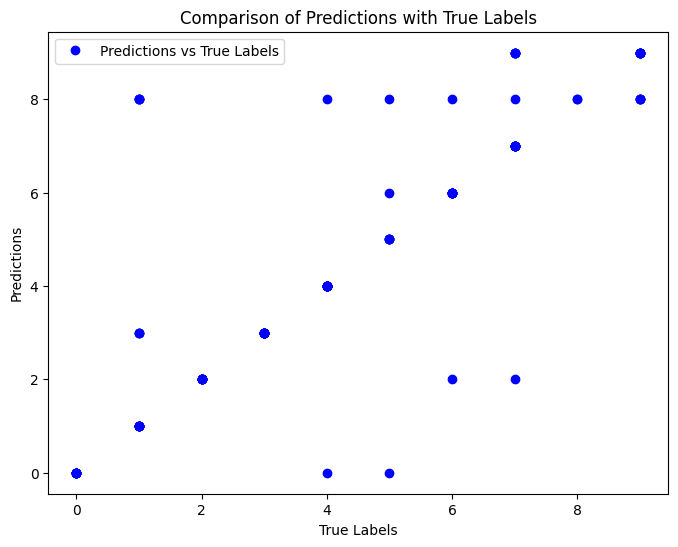

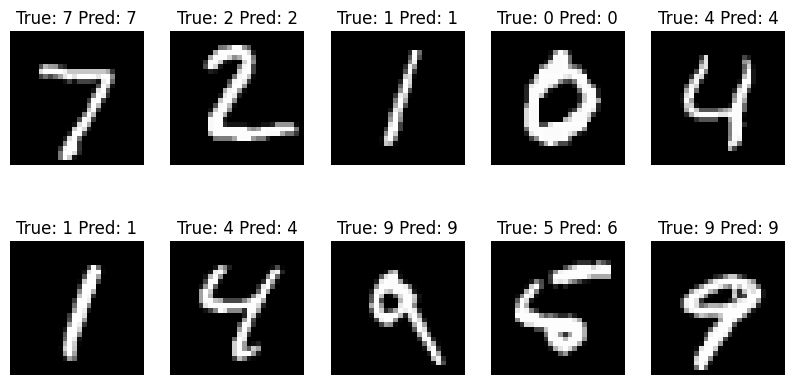

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       980
           1       1.00      0.62      0.76      1135
           2       0.92      0.83      0.87      1032
           3       0.76      0.92      0.83      1010
           4       0.95      0.80      0.87       982
           5       0.99      0.47      0.64       892
           6       0.96      0.86      0.91       958
           7       1.00      0.50      0.67      1028
           8       0.44      0.98      0.60       974
           9       0.71      0.83      0.76      1009

    accuracy                           0.78     10000
   macro avg       0.86      0.78      0.78     10000
weighted avg       0.86      0.78      0.78     10000



In [13]:
# # Analyze first model  # Replace with the actual path if needed
model_analysis(model0_path)

Net(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Train/
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Validation/
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Test/
  )
  (cm): MulticlassConfusionMatrix()
  (criterion): CrossEntropyLoss()
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
)
Number o

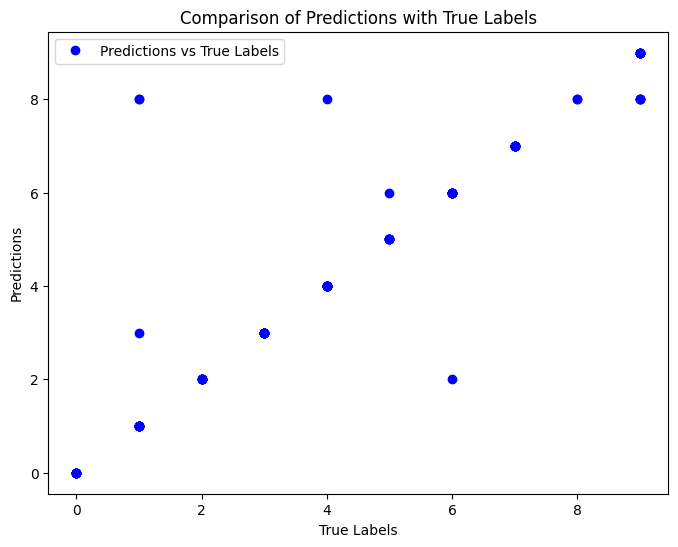

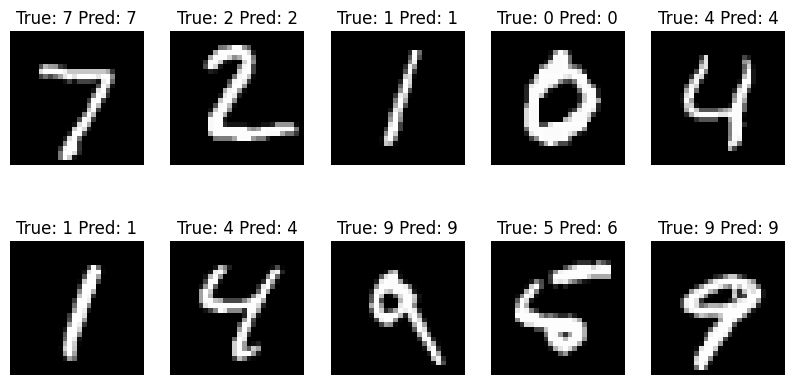

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       980
           1       0.99      0.94      0.96      1135
           2       0.95      0.94      0.94      1032
           3       0.88      0.97      0.92      1010
           4       0.99      0.83      0.90       982
           5       0.99      0.81      0.89       892
           6       0.97      0.94      0.96       958
           7       0.97      0.92      0.94      1028
           8       0.70      0.98      0.82       974
           9       0.92      0.82      0.87      1009

    accuracy                           0.92     10000
   macro avg       0.93      0.91      0.92     10000
weighted avg       0.93      0.92      0.92     10000



In [14]:
# Analyze mid model
model_analysis(model4_path)

Net(
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Train/
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Validation/
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
    (MulticlassPrecision): MulticlassPrecision()
    (MulticlassRecall): MulticlassRecall()
    (MulticlassF1Score): MulticlassF1Score(),
    prefix=Test/
  )
  (cm): MulticlassConfusionMatrix()
  (criterion): CrossEntropyLoss()
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
)
Number o

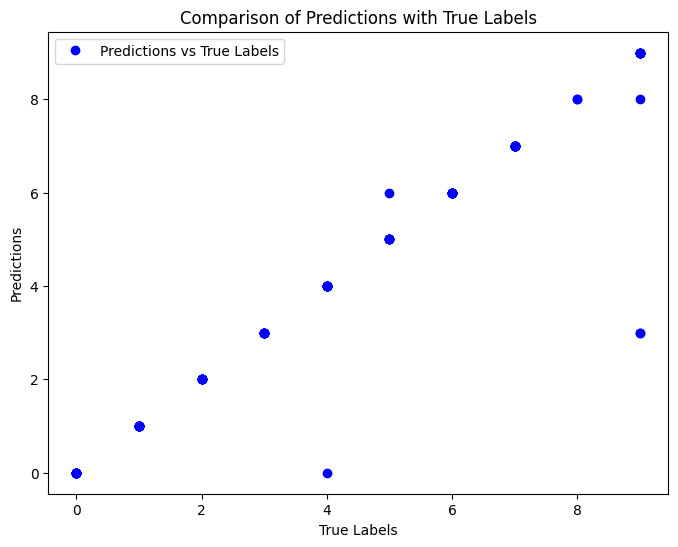

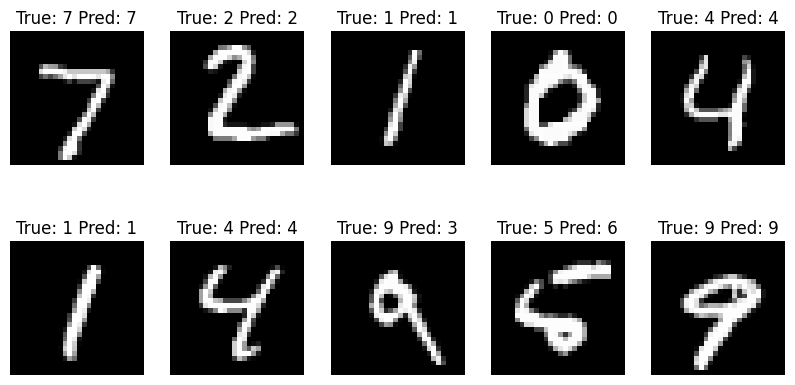

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.93      0.95      1032
           3       0.86      0.98      0.92      1010
           4       0.99      0.88      0.93       982
           5       0.99      0.89      0.93       892
           6       0.96      0.96      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.88      0.95      0.92       974
           9       0.94      0.85      0.89      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [15]:
# Analyze last model
model_analysis(model9_path)